In [8]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [7]:
# !pip install tensorflow keras
# from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
# train_path = "C:/Users/Ishit/pytorch/DL_A4/data/df_train_cleaned.csv"
# val_path = "C:/Users/Ishit/pytorch/DL_A4/data/df_dev_cleaned.csv"
# test_path = "C:/Users/Ishit/pytorch/DL_A4/data/df_test_seen.csv"
# image_path = "C:/Users/Ishit/Downloads/archive (1)/data/"

train_path = "/kaggle/input/meme-data/df_train_cleaned.csv"
val_path = "/kaggle/input/meme-data/df_dev_cleaned.csv"
test_path = "/kaggle/input/meme-data/df_test_cleaned.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
dev_df = pd.read_csv(val_path)

In [11]:
image_path = "/kaggle/input/facebook-hateful-meme-dataset/data/"

def get_image_data(data):
    images = []
    labels = []
    rows2drop = []
    for i in range(len(data)):
        img_path = image_path + data["img"][i]
        img = plt.imread(img_path)
        if img.shape[2] == 3:
            images.append(img)
            labels.append(data["label"][i])
        else:
            rows2drop.append(i)
    return images, labels, rows2drop
            

x_train_img, y_train_img, drop_train = get_image_data(train_df)
x_val_img, y_val_img, drop_dev = get_image_data(dev_df)
x_test_img, y_test_img, drop_test = get_image_data(test_df)

In [186]:
# x_train_img

In [12]:
train_df = train_df.drop(drop_train)
dev_df = dev_df.drop(drop_dev)
test_df = test_df.drop(drop_test)

In [13]:
len(x_train_img), len(y_train_img), len(x_val_img), len(y_val_img), len(x_test_img), len(y_test_img)

(4190, 4190, 249, 249, 454, 454)

In [14]:
train_text = train_df['text'].tolist()
test_text = test_df['text'].tolist()
dev_text = dev_df['text'].tolist()

In [15]:
y_train = train_df['label'].tolist()
y_test = test_df['label'].tolist()
y_dev = dev_df['label'].tolist()

In [16]:
max_len = 100
tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_df['text'])

sequences_train = tokenizer.texts_to_sequences(train_df['text'])
sequences_val = tokenizer.texts_to_sequences(dev_df['text'])
sequences_test = tokenizer.texts_to_sequences(test_df['text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

x_train_text = pad_sequences(sequences_train, maxlen=max_len)
x_val_text = pad_sequences(sequences_val, maxlen=max_len)
x_test_text = pad_sequences(sequences_test, maxlen=max_len)

y_train_text = np.array(train_df['label'])
y_val_text = np.array(dev_df['label'])
y_test_text = np.array(test_df['label'])

Found 6451 unique tokens.


In [45]:
(y_train_text == y_train_img).sum()

4190

In [17]:
len(x_train_text), len(y_train_text), len(x_val_text), len(x_val_text), len(x_test_text), len(y_test_text)

(4190, 4190, 249, 249, 454, 454)

In [82]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class MultimodalClassification(Dataset):
    def __init__(self, x_text, x_img, y, transform=None):
        self.x_text = x_text
        self.x_img = x_img
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        if self.transform:
            return self.x_text[idx], self.transform(self.x_img[idx]), self.y[idx]
        

In [128]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_dataset = MultimodalClassification(x_train_text, x_train_img, y_train_img, transform)
val_dataset = MultimodalClassification(x_val_text, x_val_img, y_val_img, transform)
test_dataset = MultimodalClassification(x_test_text, x_test_img, y_test_img, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [129]:
for text, img, label in train_loader:
    print(text.shape, img.shape, label.shape)
    break

torch.Size([32, 100]) torch.Size([32, 3, 224, 224]) torch.Size([32])


In [ ]:
import gensim.downloader as api
glove_model = api.load("glove-wiki-gigaword-100")

[=================================================-] 98.9% 126.7/128.1MB downloaded

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [203]:
import torchvision.models as models
import torch.nn.functional as F

class RES_LSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes):
        super(RES_LSTM, self).__init__()

        # LSTM
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.lstm = nn.LSTM(embedding_matrix.shape[1], hidden_size, num_layers, batch_first=True)
    
        # RES
        self.resnet = models.resnet50(pretrained=True)
        for param in self.resnet.parameters(): # freezing params
            param.requires_grad = False
        self.resnet.fc = nn.Linear(2048, 64)
        
        # Conn
        self.fc1 = nn.Linear(hidden_size*2, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = F.leaky_relu

        
    def forward(self, x_text, x_img):

        # LSTM
        h0 = torch.zeros(self.num_layers, x_text.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x_text.size(0), self.hidden_size).to(device)
        
        lstm_out = self.embedding(x_text)
        lstm_out, _ = self.lstm(lstm_out, (h0, c0)) 
        lstm_out = lstm_out[:, -1, :]                  # batch size * hidden_size(64)
       
        # Resnet
        res_out = self.resnet(x_img)  # batch_szze * 64

        
        # concatenate output
        concat_out = torch.cat((res_out, lstm_out), dim=1) # batch size * 128

        # passing through linear
        out = self.relu(self.fc1(concat_out)) # batch_size * 64
        out = self.relu(self.fc2(out))
        return out


In [204]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001
hidden_size = 64
num_layers = 2
num_classes = 2

model = RES_LSTM(torch.FloatTensor(glove_model.vectors), hidden_size, num_layers, num_classes).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [205]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [206]:
# for name, param in model.named_parameters():
#     print(f"Name: {name} : Requires Grad: {param.requires_grad}")
#     # print(f"  ")
#     # print(f"  Value: {param.data}")


In [207]:
# train the model
epochs = 20
train_losses = []
val_losses = []
train_acc = []
val_acc = []
best_acc = 0
for epoch in range(epochs):
    model.train()
    train_loss = 0
    accuracy = 0
    
    for text, img, label in train_loader:
        text = text.to(device)
        img = img.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(text, img)
        loss = criterion(outputs, label)
        
        # Backward and optimize
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        accuracy += (predicted == label).sum().item()

    train_losses.append(train_loss/len(train_loader))
    train_acc.append(100*accuracy/len(x_train_text))
    
    
    # Validation
    with torch.no_grad():
        model.eval()
        val_loss = 0
        accuracy = 0
        for text, img, label in val_loader:
            text = text.to(device)
            img = img.to(device)
            label = label.to(device)

            outputs = model(text, img)
            loss = criterion(outputs, label)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            accuracy += (predicted == label).sum().item()

        val_losses.append(val_loss/len(val_loader))
        val_acc.append(100*accuracy/len(x_val_text))

        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            best_val_accuracy_epoch = epoch
            torch.save(model.state_dict(), "vision_text_model.pt")

        print (f'Epoch [{epoch+1}/{epochs}], Loss: {train_losses[-1]} Accuracy: {train_acc[-1]} Validation Loss: {val_losses[-1]}, Accuracy: {val_acc[-1]}')


Epoch [1/20], Loss: 0.6546162234917852 Accuracy: 64.94033412887828 Validation Loss: 0.7206322252750397, Accuracy: 51.40562248995984
Epoch [2/20], Loss: 0.6395131056090347 Accuracy: 65.32219570405728 Validation Loss: 0.7995942980051041, Accuracy: 51.40562248995984
Epoch [3/20], Loss: 0.629497887296531 Accuracy: 65.34606205250597 Validation Loss: 0.7302144169807434, Accuracy: 51.40562248995984
Epoch [4/20], Loss: 0.6224828439814444 Accuracy: 64.94033412887828 Validation Loss: 0.7443951368331909, Accuracy: 54.21686746987952
Epoch [5/20], Loss: 0.6107311273804148 Accuracy: 66.49164677804296 Validation Loss: 0.8112027272582054, Accuracy: 53.81526104417671
Epoch [6/20], Loss: 0.6008406038047703 Accuracy: 67.56563245823389 Validation Loss: 0.8236957117915154, Accuracy: 52.610441767068274
Epoch [7/20], Loss: 0.5781472973696148 Accuracy: 67.87589498806683 Validation Loss: 0.9591370597481728, Accuracy: 53.01204819277108
Epoch [8/20], Loss: 0.5616111632521826 Accuracy: 70.23866348448688 Validatio

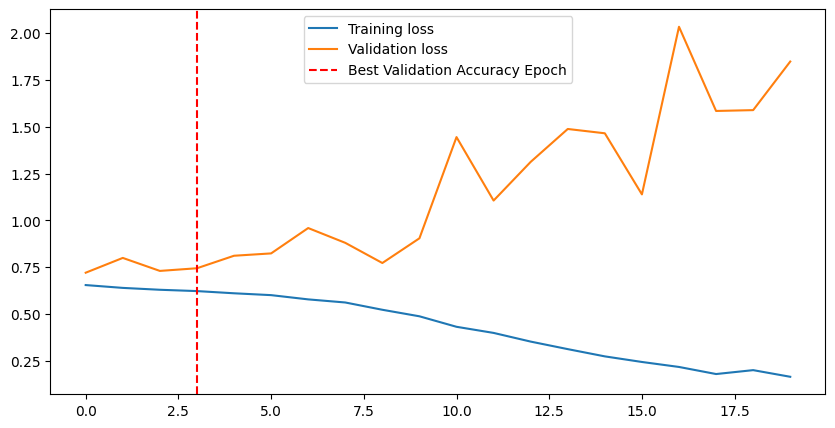

In [208]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.axvline(best_val_accuracy_epoch, color="red", linestyle="--", label="Best Validation Accuracy Epoch")
plt.legend()

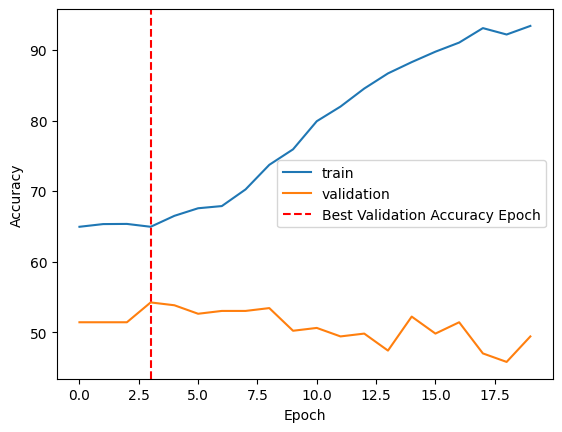

In [209]:
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.axvline(best_val_accuracy_epoch, color="red", linestyle="--", label="Best Validation Accuracy Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [211]:
# best_model = RES_LSTM(torch.FloatTensor(glove_model.vectors), hidden_size, num_layers, num_classes).to(device)
# best_model.load_state_dict(torch.load('/kaggle/working/vision_text_model.pt'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-211-1995aa09bb2e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

<All keys matched successfully>

In [213]:
# test the model and print accuracy, precision, recall, f1-score
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for text, img, label in test_loader:
        text = text.to(device)
        img = img.to(device)
        label = label.to(device)
        
        outputs = model(text, img)
        _, predicted = torch.max(outputs, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        
        y_true += label.tolist()
        y_pred += predicted.tolist()

    print(f'Accuracy: {100 * correct / total}')
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

Accuracy: 54.62555066079295
              precision    recall  f1-score   support

           0       0.53      0.67      0.59       221
           1       0.58      0.43      0.49       233

    accuracy                           0.55       454
   macro avg       0.55      0.55      0.54       454
weighted avg       0.55      0.55      0.54       454

[[148  73]
 [133 100]]
